#### Advanced Statistics for Data Science (Spring 2022)
# Home Assignment 4
#### Topics:
- ANOVA


#### Due: 10/05/2022 by 18:30

#### Instructions:
- Write your name, Student ID, and date in the cell below. 
- Submit a copy of this notebook with code filled in the relevant places as the solution of coding excercises.
- For theoretic excercises, you can either write your solution in the notebook using $\LaTeX$ or submit additional notes.

<hr>
<hr>


**Name**: Tzach Larboni

**Student ID**: 302673355

**Date**: 10.05.2022

$
\newcommand{\Id}{{\mathbf{I}}}  
\newcommand{\SSE}{\mathsf{SSE}}
\newcommand{\SSR}{\mathsf{SSR}}
\newcommand{\MSE}{\mathsf{MSE}}
\newcommand{\simiid}{\overset{iid}{\sim}}
\newcommand{\ex}{\mathbb E}
\newcommand{\var}{\mathrm{Var}}
\newcommand{\Cov}[2]{{\mathrm{Cov}  \left(#1, #2 \right)}}
\newcommand{\one}[1]{\mathbf 1 {\left\{#1\right\}}}
\newcommand{\SE}[1]{\mathrm{SE} \left[#1\right]}
\newcommand{\reals}{\mathbb R}
\newcommand{\Ncal}{\mathcal N}
\newcommand{\abs}[1]{\ensuremath{\left\vert#1\right\vert}}
\newcommand{\rank}{\operatorname{rank}}
\newcommand{\tr}{\operatorname{Tr}}
\newcommand{\diag}{\operatorname{diag}}
\newcommand{\sign}{\operatorname{sign}}
$


<hr>
<hr>

# Problem 1 (Solving LS using SVD)
Consider the housing prices dataset (``housing_prices.csv``). Use houses of lot size smaller than 15000 ft.

1. Find the least squares coefficient of the linear model with target variable ``SalePrice`` and the 16 predictors:
``['LotArea',  'YearBuilt',
  'GarageCars', 'YrSold', 'MoSold', 'Fireplaces',
  'HalfBath', 'LowQualFinSF', 'TotalBsmtSF',
  '1stFlrSF', 'LotFrontage', 'ScreenPorch',
   'WoodDeckSF', 'OverallCond', 'BsmtUnfSF']`` 
plus a constant term. Remove all entries in which one or more of these predictors is missing. 
 - By inverting the matrix $Z^\top Z$. Denote the solution $\hat{\beta}$.
 - Using the SVD method. Here, decide that $\sigma_i > 0$ if $\sigma_i / \sigma_1 > 10^{-6}$. Denote the solution $\hat{\beta}^{SVD}$.
 - In which method $R^2$ is smaller?
2. Plot $\hat{y}$ and $\hat{y}^{SVD}$ over the same pannel to convince yourself that both methods resulted in similar fitted responses. 
3. Plot $\log(|\hat{\beta}_i/\hat{\beta}^{SVD}_i|)$ vs. $i$ for $i=1,\ldots,p$ and indicate the covariate whose coefficient exhibits the largest difference between the methods.

The point: When there are many predictors, it is likely that $Z$ will be rank deficient in the sense that some of its singular values are very small. Removing those singular values is usually a good practice; it is important to observe how this removal affects the solution. 

The largest difference is for the first predictor, which is the constant covariate. We can check that this result makes sense by fiting a new model without the constant covaraite and test whether the residuals in the smaller new model are not significantly different than those in the original model. 

You can use the code below to read and arrange the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [2]:
target = 'SalePrice' 
lo_predictors = ['const', 'SalePrice', 'LotArea',  'YearBuilt',
    'GarageCars', 'YrSold', 'MoSold', 'Fireplaces',
    'HalfBath', 'LowQualFinSF', 'TotalBsmtSF',
    '1stFlrSF', 'LotFrontage', 'ScreenPorch',
     'WoodDeckSF', 'OverallCond', 'BsmtUnfSF']

data = pd.read_csv("housing_prices.csv")
data = data[data.LotArea < 15000]  # we focus on small lots
data['const'] = 1                  # add constant term
data = data.filter(lo_predictors).dropna() # remove all other columns

y = data[target].values
X = data.drop(target, axis=1)
Z = X.values
n, p = Z.shape

data.head()

,const,SalePrice,LotArea,YearBuilt,GarageCars,YrSold,MoSold,Fireplaces,HalfBath,LowQualFinSF,TotalBsmtSF,1stFlrSF,LotFrontage,ScreenPorch,WoodDeckSF,OverallCond,BsmtUnfSF
0,1,208500,8450,2003,2,2008,2,0,1,0,856,856,65.0,0,0,5,150
1,1,181500,9600,1976,2,2007,5,1,0,0,1262,1262,80.0,0,298,8,284
2,1,223500,11250,2001,2,2008,9,1,1,0,920,920,68.0,0,0,5,434
3,1,140000,9550,1915,3,2006,2,1,0,0,756,961,60.0,0,0,5,540
4,1,250000,14260,2000,3,2008,12,1,1,0,1145,1145,84.0,0,192,5,490


#### Part 1

##### Find $\hat{\beta}$ 

In [3]:
beta_hat_ls = np.linalg.inv(Z.T @ Z) @ Z.T @ y
print(f"The LS estimator Beta hat is the vector {[round(b,2) for b in list(beta_hat_ls)]}^T")

The LS estimator Beta hat is the vector [-3039719.75, 2.98, 616.84, 21256.55, 884.95, 983.79, 16763.36, 27915.65, 68.96, 43.9, 41.28, 0.73, 22.67, 30.83, 7715.94, -8.1]^T



##### Find $\hat{\beta}^{SVD}$ 

In [4]:
epsilon = 10 ** -6

u, sig, v_t = np.linalg.svd(Z, full_matrices=False)
# np.allclose((u * sig) @ v_t, Z) 
r = np.linalg.matrix_rank(Z, tol=epsilon)
y_star = u.T @ y
beta_star = y_star / sig
beta_hat_svd = v_t.T @ beta_star

print(f"The LS estimator Beta hat is the vector {[round(b,2) for b in list(beta_hat_svd)]}^T")

The LS estimator Beta hat is the vector [-3039719.75, 2.98, 616.84, 21256.55, 884.95, 983.79, 16763.36, 27915.65, 68.96, 43.9, 41.28, 0.73, 22.67, 30.83, 7715.94, -8.1]^T


##### Compre $R^2$

In [5]:
def calc_r_squared(y, Z, beta_hat):
    y_hat = Z @ beta_hat
    y_bar = np.mean(y)
    ss_fit = np.sum((y_hat - y_bar)**2)
    ss_tot = np.sum((y - y_bar)**2)

    r_squared = ss_fit / ss_tot
    return r_squared

In [7]:
smaller_r_squared = "LS" if calc_r_squared(y, Z, beta_hat_ls) < calc_r_squared(y, Z, beta_hat_svd) else "SVD"

print(f"The R^2 for the Z^T Z approach is {calc_r_squared(y, Z, beta_hat_ls):.3f} and for the SVD approach is {calc_r_squared(y, Z, beta_hat_svd):.3f}.\nHowever, {smaller_r_squared} have a slighly smaller R^2 value.")


The R^2 for the Z^T Z approach is 0.745 and for the SVD approach is 0.745.
However, LS have a slighly smaller R^2 value.


#### Part 2

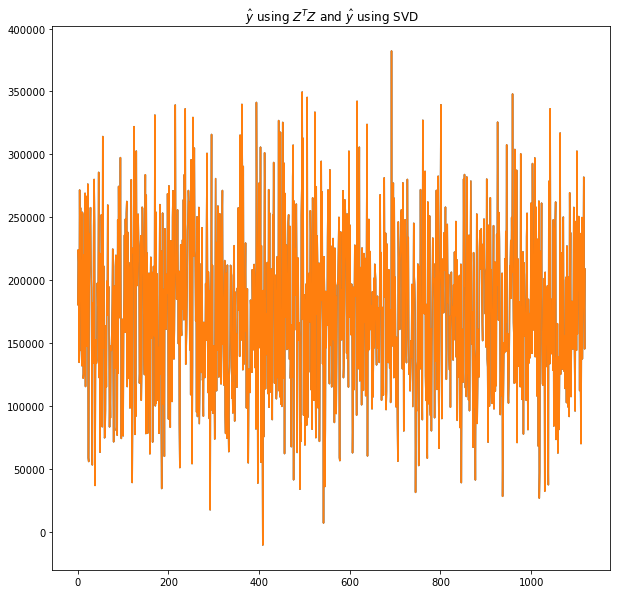

In [8]:
y_hat_mat = Z @ beta_hat_ls
y_hat_svd = Z @ beta_hat_svd

plt.rcParams['figure.figsize'] =  [10, 10]

plt.plot(y_hat_mat)
plt.plot(y_hat_svd)
plt.title(r"$\hat{y}$ using $Z^TZ$ and $\hat{y}$ using SVD")
plt.show()

#### Part 3

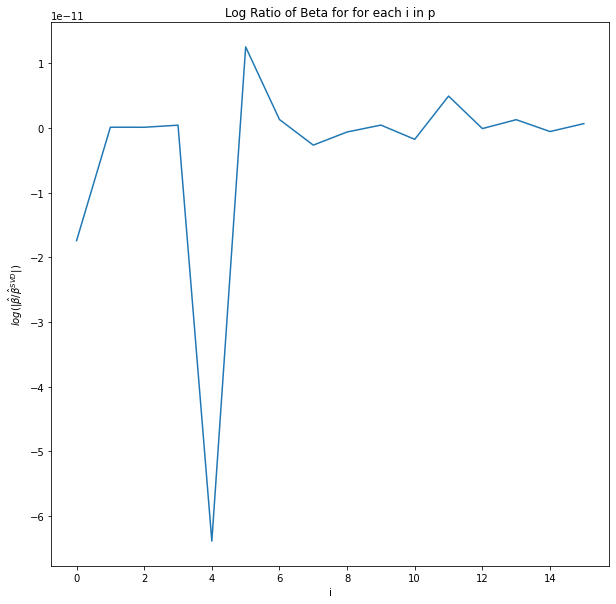

In [10]:
xs = []
for i in range(p):
    xs.append(np.log(abs(beta_hat_ls[i] / beta_hat_svd[i])))
    
plt.plot(xs)
plt.xlabel("i")
plt.ylabel(r"$log(|\hat{\beta} / \hat{\beta}^{SVD}|)$")
plt.title("Log Ratio of Beta for for each i in p")
plt.show()

As it seems, the 4th coefficient, `GarageCars`, has the largest difference between the two methods.

## Problem 2 ($t$-test is a kind of ANOVA)
Consider the following two-sample problem. The data is
$$
y_{ij} = \mu_i + \epsilon_{ij},\qquad j=1,\ldots,n_i,\quad i=0,1. 
$$

1. Find the statistic $t$ for the two-sample $t$ test (using of the observable varaibles)
2. Write the ANOVA table for $k=2$ and find the F statistic $F$ (using of the observable varaibles)
3. Conclude that $t^2 = F$. 
4. Does the test that rejects when $|t| > t_{n-1}^{1-\alpha/2}$ has larger power than the test that rejects when $F > F_{1,n-1}^{1-\alpha}$ ? less? same? 


#### Part 1

$$ t = \frac{\mu_0 - \mu_1}{\sqrt{\frac{s^2}{n_0} + \frac{s^2}{n_1}}}$$

Where $$s^2 = \frac {\sum_{i=1}^{n_1}(y_{1i}-\mu_1)^2 + \sum_{i=1}^{n_0}(y_{0i}-\mu_0)^2 } {n_0+n_1-2} $$


#### Part 2

| Source | DoF | SS | MS | F |
| :- | -: | :-: | :- | -: |
| Groups | 1 | $SS_{between} = \sum_{i=0}^{1}{n_i(\mu_i - \bar{y})^2}$ | $\frac{SS_{bet}}{1}$ | $\frac{MS_{bet}}{MS_{wit}}$ |  
| Error | n - 2 | $SS_{within} = \sum_{i=0}^{1} \sum{j=1}^{n_i} ({y_{i,j} - \mu_i)^2}$ | $\frac{SS_wit}{n-2}$| |
| Total | n - 1 | $SS_total = \sum{i=0}^{1} \sum{j=1}^{n_1} (y_{i,k} - \hat{y})^2)$| | | 

#### Part 3

We know that $$ F = \frac{MS_{bet}}{MS_{wit}} = \frac{\frac{SS_{bet}}{k-1}}{\frac{SS_{wit}}{n-k}}$$ 
$$ t^2 = \frac{(\bar{y_0} - \bar{y_1})^2}{s^2(\frac{1}{n_0} + \frac{1}{n_2})}$$

While $k=2$. 

We can start by examining the numerator of $F$:
$$ \frac{SS_{bet}}{2-1} = SS_{bet} = \sum_{i=0}^{1}{n_i(\mu_i - \bar{y})^2} = n_0(\mu_0 - \bar{y})^2 + n_1(\mu_1 - \bar{y})^2$$

Since $ \bar{y} = \frac{n_0 \mu_0+ n_1 \mu_1}{n_0 + n_1} $, we'll plug it in and examine each argument, starting from the left:

$$
n_0 (\mu_0 - \frac{n_0 \mu_0+ n_1 \mu_1}{n})^2 = n_0 [\frac{(n-n_0) \mu_0 - n_1 \mu_1}{n}]^2
$$
$$
= n_0(\frac{n_1 \mu_0 - n_1 \mu_1}{n})^2
$$
$$
= \frac{n_0n_1^2}{n^2}(\mu_0 - \mu_1)^2
$$

We'll do the same for the right argument and get:
$$
n_1(\mu_1 - \bar{y})^2 = \frac{n_1n_0^2}{n^2}(\mu_1 - \mu_0)^2
$$

Meaning, 

$$
SS_{bet} = \frac{n_0n_1^2}{n^2}(\mu_0 - \mu_1)^2 + \frac{n_1n_0^2}{n^2}(\mu_1 - \mu_0)^2 = (\frac{n_0 n_1 ^2 + n_1 n_0^2}{n^2}) (\mu_0 - \mu_1)^2
$$

$$
= \frac{n_0 n_1 n}{n^2}(\mu_0 - \mu_1)^2 = \frac {n_0 n_1}{n} (\mu_0 - \mu_1)^2
$$

$$
= \frac{1}{\frac{n}{n_0 n_1}} (\mu_0 - \mu_1)^2 = \frac{(\mu_0 - \mu_1)^2}{\frac{1}{n_0} + \frac {1}{n_1}} 
$$
Moving on to the denominator:
$${\frac{SS_{wit}}{n-2}} = \frac{\sum_{j=1}^{n_0}(y_{0j} - \bar{y_0})^2  + \sum_{j=1}^{n_1}(y_{1j} - \bar{y_1})^2}{n_0 + n_1 -2}$$

If we'll recall the formula for $s^2$, we can see it's equivilant and get that 
$$ {\frac{SS_{wit}}{n-2}} = s^2 $$

And plugging it all back together we'll get:

$$
F = \frac{SS_{bet}}{\frac{SS_{wit}}{n-2}} = \frac{(\mu_0 - \mu_1)^2} {s^2(\frac{1}{n_0} + \frac{1}{n_1})} = t^2
$$

$$ Q.E.D$$

#### Part 4


The a null hypothesis under $|t| > t_{n-1}^{1-\alpha/2}$ test does have a larger power than rejecting one under $F > F_{1,n-1}^{1-\alpha}$ test.
While the $t$ test refers to a specific comparison between two populations while the $F$ test relies to multiple populations. In that sense, being able to say something two specific populations seems stronger. 

## Problem 3 (ANOVA Decomposition)
In class, we considered the decomposition:
$$
\begin{equation}
\mathrm{SS}_{tot} = \mathrm{SS}_{within} + \mathrm{SS}_{between}
\label{eq:ANOVA} \tag{1}
\end{equation}
$$
where
$$
\mathrm{SS}_{between} = \sum_{i=1}^k n_i(\bar{y}_{i\cdot} - \bar{y}_{\cdot \cdot})^2,\qquad \mathrm{SS}_{within} = \sum_{i=1}^k \sum_{j=1}^{n_i} (y_{ij} - \bar{y}_{i\cdot})^2
$$
Prove $\eqref{eq:ANOVA}$ by expanding:
$$
\mathrm{SS}_{tot} = \sum_{i=1}^k \sum_{j=1}^{n_i} (y_{ij} - \bar{y}_{\cdot \cdot})^2 = \sum_{i=1}^k \sum_{j=1}^{n_i} (y_{ij} - \bar{y}_{i\cdot} + \bar{y}_{i\cdot} - \bar{y}_{\cdot \cdot})^2 = ...
$$

#### Answer

$${SS}_{tot} = \sum_{i=1}^k \sum_{j=1}^{n_i} (y_{ij} - \bar{y}_{\cdot \cdot})^2$$
$$\sum_{i=1}^k \sum_{j=1}^{n_i} (y_{ij} - \bar{y}_{i\cdot} + \bar{y}_{i\cdot} - \bar{y}_{\cdot \cdot})^2 $$

We can treat it as $(a+b)^2 = a^2 + 2ab + b^2)$ and:

$$\sum_{i=1}^k \sum_{j=1}^{n_i} [(y_{ij} - \bar{y}_{i\cdot})^2 + 2(\bar{y}_{i\cdot} - \bar{y}_{\cdot \cdot})(y_{ij} - \bar{y}_{i\cdot}) + (\bar{y}_{i\cdot} - \bar{y}_{\cdot \cdot})^2] $$

We can open the summations:

$$\sum_{i=1}^k \sum_{j=1}^{n_i} (y_{ij} - \bar{y}_{i\cdot})^2 + 2\sum_{i=1}^k \sum_{j=1}^{n_i} (\bar{y}_{i\cdot} - \bar{y}_{\cdot \cdot})(y_{ij} - \bar{y}_{i\cdot}) + \sum_{i=1}^k \sum_{j=1}^{n_i}(\bar{y}_{i\cdot} - \bar{y}_{\cdot \cdot})^2 $$

We can see that the leftmost argument is basically $SS_{between}$ and that the rightmost argument is $SS_{within}$, therefore:

$$ SS_{between} + 2\sum_{i=1}^k \sum_{j=1}^{n_i} (\bar{y}_{i\cdot} - \bar{y}_{\cdot \cdot})(y_{ij} - \bar{y}_{i\cdot}) + SS_{within}$$

We will now focus on the middle argument:

$$ 2\sum_{i=1}^k \sum_{j=1}^{n_i} (\bar{y}_{i\cdot} - \bar{y}_{\cdot \cdot})(y_{ij} - \bar{y}_{i\cdot})$$
Since there is not j in the right argument, we can move the $j$ summation inside:
 $$2 \sum_{i=1}^k (\bar{y}_{i\cdot} - \bar{y}_{\cdot \cdot}) [\sum_{j=1}^{n_i} (y_{ij} - \bar{y}_{i\cdot})]$$
 
We can further play with the summation, converting on of it to simple multiplication:
$$2 \sum_{i=1}^k (\bar{y}_{i\cdot} - \bar{y}_{\cdot \cdot}) [(\sum_{j=1}^{n_i} (y_{ij}) - n\bar{y}_{i\cdot})]$$

Since the two right most expresssions are identical we get:

$$2 \sum_{i=1}^k (\bar{y}_{i\cdot} - \bar{y}_{\cdot \cdot}) \times 0 = 0$$

Hence:
$$ SS_{tot} = SS_{between} + 0 + SS_{within}$$
$$Q.E.D$$

## Problem 4 (ANOVA and multiple testing in Practice)

Consider Israeli wines in the wine dataset ``winemag-data_first150k.csv`` used in class (downloaded from Kaggle https://www.kaggle.com/datasets/zynicide/wine-reviews?select=winemag-data_first150k.csv). Use ANOVA to measure the effect of winary (``winary``) on the quality (``points``) of wine of veriaty ``Cabernet Sauvignon``. 
1. Load dataset; keep only relevant records according to the fields ``country`` and ``veriaty``; remove winaries with 1 or less samples (because we cannot do ANOVA for those)
2. Plot the boxplot with ``winary`` as the x-axis and ``points`` as the y-axis.
3. Use ANOVA to figure out whether some winaries make better cabernets than others; print the ANOVA table and explain your conclusion
4. Find which winaries have cabernets ranked higher than others:
 - Run all paired t-tests; how many of the test's P-values fall below 0.05? is it more than what is expceted if all tests are null?
 - Use Bonferroni's method to decide which winaries ranked singnificantly higher than others by reporting on the list of pairs whose P-value is significant after Bonferroni's correction. Also indicate which one is ranked higher out of each pair.

#### Part 1
1. Load dataset; keep only relevant records according to the fields ``country`` and ``veriaty``; remove winaries with 1 or less samples (because we cannot do ANOVA for those)

In [11]:
wine_df = pd.read_csv('winemag-data_first150k.csv')
wine_df = wine_df[(wine_df.country == 'Israel') & (wine_df.variety == 'Cabernet Sauvignon')]
wine_df = wine_df[['winery', 'points']]
v = wine_df.winery.value_counts()
relevant_wineries = v.index[v.gt(1)]
wine_df = wine_df[wine_df.winery.isin(relevant_wineries)]
wine_df.head(10)

,winery,points
81,Binyamina,91
355,Bazelet HaGolan,91
966,Segal's,90
970,Tabor,90
977,Yatir,90
1205,Carmel,90
1476,Carmel,90
1806,Or Haganuz,90
1812,Shiloh Winery,90
2671,Flam,90


#### Part 2
2. Plot the boxplot with ``winary`` as the x-axis and ``points`` as the y-axis.


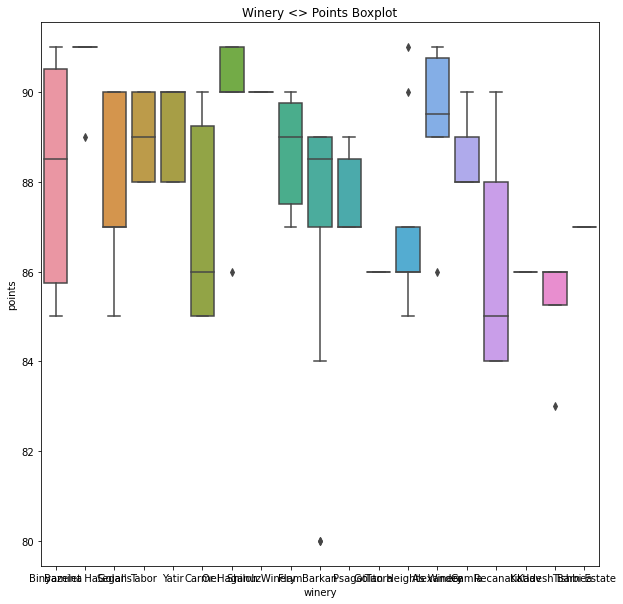

In [12]:
sns.boxplot(x='winery', y='points', data=wine_df)
plt.title('winery <> points boxplot'.title())
plt.show()

#### Part 3
3. Use ANOVA to figure out whether some winaries make better cabernets than others; print the ANOVA table and explain your conclusion

In [13]:
def ssquares(x):
    return np.sum((x - np.mean(x)) ** 2)

ss_wit = wine_df.groupby('winery')['points'].agg(ssquares).sum()
ss_tot = np.sum((wine_df['points'] -  wine_df['points'].mean()) ** 2)

n, k = len(wine_df), len(relevant_wineries)

ss_bet = ss_tot - ss_wit

MSE_bet = ss_bet / (k-1)
MSE_wit = ss_wit / (n-k)

F = MSE_bet / MSE_wit
print(f"DoF: Wineries = {k-1}, Error = {n-k}, Total = {n-1}")
print(f"SS: Wineries = {ss_bet:.2f}, Error = {ss_wit:.2f}, Total = {ss_tot:.2f}")
print(f"MS: Wineries = {MSE_bet:.2f}, Error = {MSE_wit:.2f}")
print(f"F = {F:.2f}")
print(f"Pvalue = {st.f.sf(F, k-1, n-k):.5f}")


DoF: Wineries = 18, Error = 116, Total = 134
SS: Wineries = 240.83, Error = 470.11, Total = 710.93
MS: Wineries = 13.38, Error = 4.05
F = 3.30
Pvalue = 0.00005


Since all of the stats for the ANOVA table are written above, I would simply use the shelf function to print the ANOVA table itself, as was shown in class:

In [14]:
model = ols('points ~ winery', data=wine_df).fit()
anova = sm.stats.anova_lm(model, typ=2)
anova

,sum_sq,df,F,PR(>F)
winery,240.827276,18.0,3.301378,0.000051
Residual,470.106057,116.0,NaN,NaN


As it seems, there are some wineries that have higher point average than others, as the p vlaue for the F test, assuming all point averages are equal, is lower than almost any $\alpha$, and specifically $\alpha = 0.05$.

#### Part 4
4. Find which winaries have cabernets ranked higher than others:
 - Run all paired t-tests; how many of the test's P-values fall below 0.05? is it more than what is expceted if all tests are null?
 - Use Bonferroni's method to decide which winaries ranked singnificantly higher than others by reporting on the list of pairs whose P-value is significant after Bonferroni's correction. Also indicate which one is ranked higher out of each pair.

In [17]:
alpha = 0.05

def paired_t_test(wine_df, winery_i, winery_j, mse_bet, n=n, k=k):
    
    array_i = np.array(wine_df[wine_df.winery == winery_i]['points'])
    array_j = np.array(wine_df[wine_df.winery == winery_j]['points'])
    
    y_i_bar, y_j_bar = np.mean(array_i), np.mean(array_j)
    
    n_i, n_j = len(array_i), len(array_j)
    
    dof = n - k
    t_num = y_i_bar - y_j_bar
    t_den = np.sqrt(mse_bet / dof) * np.sqrt(1 / n_i + 1 / n_j)
        
    p_val = st.t.sf(t_num / t_den, df=dof)
    return {"p_val": p_val,
           "winery_i": winery_i,
           "winery_j": winery_j}


def num_comparisons(n, r):
    return math.floor(math.factorial(n) /
                math.factorial(n - r))

In [19]:
sig_comparisons = 0
tot_comparisons = 0
for winery_i in relevant_wineries:
    for winery_j in relevant_wineries:
        
        if winery_i == winery_j:
            continue
            
        tot_comparisons += 1
        
        if paired_t_test(wine_df, winery_i, winery_j, MSE_bet)['p_val'] * 2 < alpha:
            sig_comparisons += 1

print (f"There are {sig_comparisons} significant comparisons out of {tot_comparisons} comparisons.")

There are 150 significant comparisons out of 342 comparisons.


Indeed, it seems that 43% of comparisons are significant, which is more than what was expected if all tests are null. I'll try again with the Bonferroni correction for multiple testing:

In [20]:
sig_comparisons = 0
tot_comparisons = 0
for winery_i in relevant_wineries:
    for winery_j in relevant_wineries:
        
        if winery_i == winery_j:
            continue
            
        tot_comparisons += 1
        
        m = num_comparisons(len(relevant_wineries), 2)
        p_val = paired_t_test(wine_df, winery_i, winery_j, MSE_bet)['p_val']
        
        if p_val * 2 < alpha / m:
            sig_comparisons += 1
            print(f"It seems that {winery_i} is has significantly higher rank than {winery_j}. P value = {p_val:.5f}")

print (f"There are {sig_comparisons} significant comparisons out of {tot_comparisons} comparisons.")

It seems that Barkan is has significantly higher rank than Recanati. P value = 0.00000
It seems that Barkan is has significantly higher rank than Kadesh Barnea. P value = 0.00000
It seems that Barkan is has significantly higher rank than Katlav. P value = 0.00000
It seems that Barkan is has significantly higher rank than Titora. P value = 0.00000
It seems that Carmel is has significantly higher rank than Recanati. P value = 0.00000
It seems that Carmel is has significantly higher rank than Kadesh Barnea. P value = 0.00000
It seems that Carmel is has significantly higher rank than Katlav. P value = 0.00000
It seems that Carmel is has significantly higher rank than Titora. P value = 0.00006
It seems that Golan Heights Winery is has significantly higher rank than Recanati. P value = 0.00000
It seems that Golan Heights Winery is has significantly higher rank than Kadesh Barnea. P value = 0.00000
It seems that Golan Heights Winery is has significantly higher rank than Katlav. P value = 0.00